In [1]:
import os
import glob
import gsw
import xarray as xr
import numpy as np
import cftime
import netCDF4 as nc
import matplotlib.pyplot as plt

from osprey.actions.forecaster import forecaster_EOF_def
from osprey.graphics.timeseries import timeseries 
from osprey.means.eof import preproc_pattern_3D
from osprey.utils.folders import folders
from osprey.utils import run_cdo 

In [2]:
expname = "FE05"
varname = "thetao"
ndim ="3D"
endleg = 11
yearspan = 5
yearleap = 30
dirs = folders(expname)
varnames = ['thetao']

In [ ]:
timeseries(expname='FE05', startyear=1990, endyear=2005, varlabel='thetao', reader='post', color='blue', linestyle='-', label='EOF-TS')

In [3]:
rdata = forecaster_EOF_def(expname=expname, varnames=varnames, endleg=endleg, yearspan=yearspan, yearleap=yearleap, mode='full', smoothing=True)

2024-10-25 15:40:15,970 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/FE05/011/FE05_00058432_restart.nc']
2024-10-25 15:40:16,874 - INFO - Data available in the range 1996-2000.
2024-10-25 15:40:19,866 - INFO - File /ec/res4/scratch/itas/martini/FE05/011/thetao_anomaly.nc successfully removed.
2024-10-25 15:40:19,867 - INFO - Detrending variable thetao by subtracting the time average.
2024-10-25 15:40:21,201 - INFO - Execution of detrend finished.
2024-10-25 15:40:21,202 - INFO - File /ec/res4/scratch/itas/martini/FE05/011/thetao_variance.nc successfully removed.
2024-10-25 15:40:21,203 - INFO - File /ec/res4/scratch/itas/martini/FE05/011/thetao_pattern.nc successfully removed.
2024-10-25 15:40:21,203 - INFO - Computing EOF for variable thetao with window size 5.
2024-10-25 15:40:21,648 - INFO - Computing EOF coefficients for thetao.
2024-10-25 15:40:22,330 - INFO - EOF computation completed successfully: /ec/res4/scratch/itas/martini/FE05/011/thetao_variance.nc, /ec/res4

/ec/res4/scratch/itas/martini/FE05/011


2024-10-25 15:40:22,681 - INFO - File /ec/res4/scratch/itas/martini/FE05/011/thetao_smoother.nc successfully removed.


In [4]:
rdata

<xarray.Dataset> Size: 90MB
Dimensions:       (y: 148, x: 180, nav_lev: 31, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 4B 5.843e+04
    lon           (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lat           (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    nav_lat       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    kt            float64 8B ...
    ndastp        float64 8B ...
    adatrj        float64 8B ...
    ntime         float64 8B ...
    ...            ...
    sshn          (time_counter, y, x) float64 213kB dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
    un            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    vn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    tn            (time_counter, nav_lev, y, x) float32 3MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    sn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    rhop          (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/FE05/011/FE05_00058432_restart.nc
    TimeStamp:  24/10/2024 08:26:42 -0000

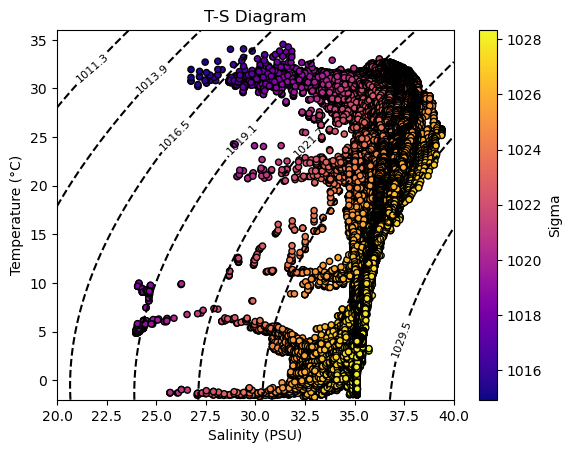

In [5]:
#from osprey.actions.reader import reader_nemo
#rdata = reader_nemo(expname='lgr3', startyear=2349, endyear=2349)
#rdata = rdata.isel(time=6)

# Define the ranges for temperature and salinity
temp_range = np.linspace(-2, 36, 100)  # Temperature in degrees Celsius
salt_range = np.linspace(20, 40, 100)   # Salinity in PSU
pres_range = np.linspace(0, 0, 100) 

# Create meshgrid for T-S space
T, S = np.meshgrid(temp_range, salt_range)

# Calculate potential density for the T-S grid at a reference pressure of 0 dbar
#density_grid = gsw.sigma0(S, T)  # sigma0 is potential density anomaly with reference to 0 dbar
density_grid = gsw.density.rho(S, T, pres_range)

# Plot 10 isolines at constant density
density_levels = np.linspace(np.nanmin(density_grid), np.nanmax(density_grid), 10)
contours = plt.contour(S, T, density_grid, levels=density_levels, colors='black', linestyles='--')
plt.clabel(contours, inline=True, fmt="%.1f", fontsize=8)

# Filter out zero values in salinity and temperature data
salinity_data = rdata['sn'].values  # Assuming salinity is in PSU
temperature_data = rdata['tn'].values # Assuming temperature is in °C
pressure = gsw.p_from_z(-rdata['nav_lev'], rdata['nav_lat'])
pressure_data = pressure.values
mask = (salinity_data != 0) & (temperature_data != 0)
filtered_salinity = salinity_data[mask]
filtered_temperature = temperature_data[mask]
filtered_pressure = filtered_temperature*0

# Calculate density for each filtered data point
#local_density = gsw.sigma0(filtered_salinity, filtered_temperature)
local_density = gsw.density.rho(filtered_salinity, filtered_temperature, filtered_pressure)

# Overlay data points colored by their local density
sc = plt.scatter(filtered_salinity, filtered_temperature, c=local_density, cmap="plasma", edgecolor='k', s=20)
colorbar_data = plt.colorbar(sc)
colorbar_data.set_label("Sigma")

# Labels and title
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (°C)")
plt.title("T-S Diagram")
plt.show()

In [6]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{varname}.nc")
data = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
leg=11
filename = os.path.join(dirs['tmp'], str(leg).zfill(3), "FE05_*_restart.nc")
sdata = xr.open_mfdataset(filename, use_cftime=True)

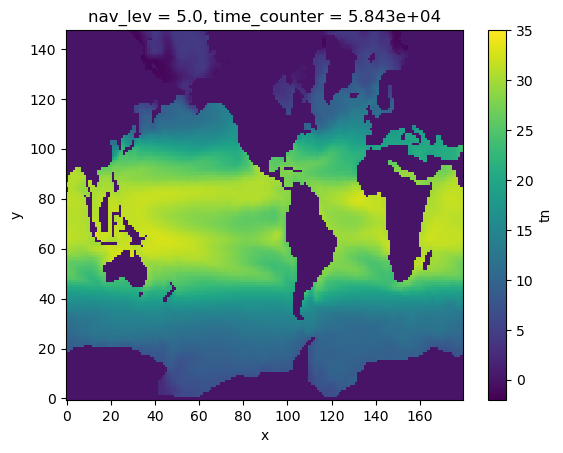

In [7]:
# restart no smoothing
rdata['tn'].isel(nav_lev=0,time_counter=0).plot(vmin=-2, vmax=35)

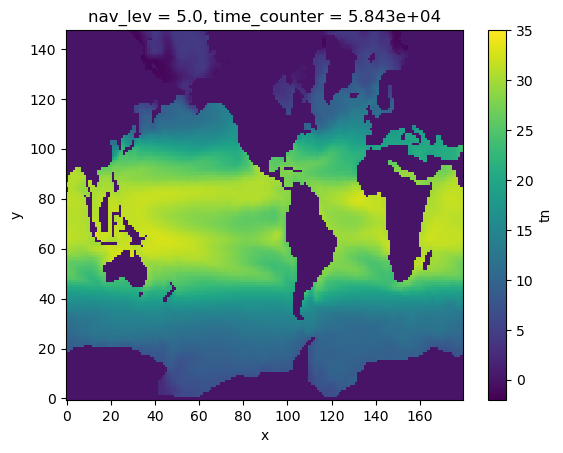

In [12]:
# restart with smoothing
rdata['tn'].isel(nav_lev=0,time_counter=0).plot(vmin=-2, vmax=35)

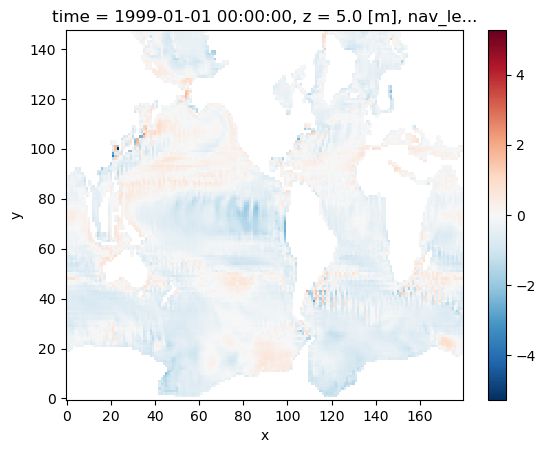

In [6]:
# full, with smoothing
delta = data[varname].isel(time=-1,z=0)-rdata['tn'].isel(nav_lev=0,time_counter=0)
delta.plot()

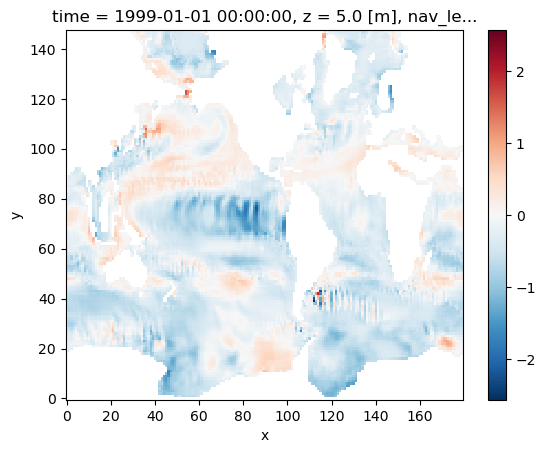

In [7]:
# full, no smoothing
delta = data[varname].isel(time=-1,z=0)-rdata['tn'].isel(nav_lev=0,time_counter=0)
delta.plot()

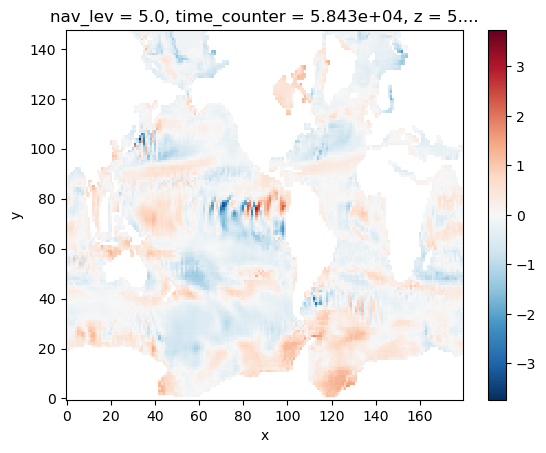

In [14]:
delta = sdata['tn'].isel(time_counter=0,nav_lev=0)-rdata['thetao'].isel(z=0)
delta.plot()